In [1]:
import os, glob, warnings
import numpy as np
import pandas as pd
import cv2
import numpy as np
import librosa
import moviepy.editor as mp
from skimage import color
from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA
import seaborn as sns
from skimage.feature import graycomatrix, graycoprops
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


warnings.filterwarnings("ignore")

In [2]:
DATA_DIR = "./data"
GT_FILES = glob.glob(os.path.join(DATA_DIR, "*.xlsx"))
VIDEO_FILES = glob.glob(os.path.join(DATA_DIR, "episodes", "*.avi"))
CACHE_FILE = os.path.join(DATA_DIR, "visual_features.npz")

SEED = 12332287
CLASSES = ["MissPiggy", "OtherPigs", "SwedishChef", "Rowlf"]

SAMPLE_VIDEO_FILE = VIDEO_FILES[0]
SAMPLE_FRAME_NUMBER = 2500

GT_REQUIRED = [
    "Video", "Frame_number", "Timestamp",
    "Kermit", "Pigs", "Miss Piggy", "Cook",
    "StatlerWaldorf", "Rowlf the Dog", "Fozzie Bear"
]

GT_TO_INTERNAL = {
    "Miss Piggy": "MissPiggy",
    "Pigs": "OtherPigs",
    "Cook": "SwedishChef",
    "Rowlf the Dog": "Rowlf",
}

np.random.seed(SEED)

In [3]:
def load_sample_frame(video_path, frame_number=2500):
    """Load a specific frame from a video file"""
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    cap.release()
    if not ret:
        raise RuntimeError(f"Failed to load frame {frame_number} from {video_path}")
    return frame

### Load Ground Truth

In [5]:
def read_ground_truth(gt_dir):
    """reads all ground truth xlsx files and returns df indexed by (Video, Frame_number)"""
    files = sorted(glob.glob(os.path.join(gt_dir, "*.xlsx")))
    if not files:
        raise FileNotFoundError("no ground truth xlsx found in gt_dir")

    dfs = []
    for path in files:
        df = pd.read_excel(path)

        # verify headers
        missing = [c for c in GT_REQUIRED if c not in df.columns]
        if missing:
            raise ValueError(f"{os.path.basename(path)} missing columns: {missing}")

        # enforce numeric dtypes
        df["Video"] = pd.to_numeric(df["Video"], errors="coerce").astype("Int64")
        df["Frame_number"] = pd.to_numeric(df["Frame_number"], errors="coerce").astype("Int64")

        # map exact GT columns to internal class names
        for gt_col, internal in GT_TO_INTERNAL.items():
            df[internal] = pd.to_numeric(df[gt_col], errors="coerce").fillna(0).astype(int)

        dfs.append(df[["Video", "Frame_number"] + list(GT_TO_INTERNAL.values())])

    gt = pd.concat(dfs, ignore_index=True)
    gt = gt.dropna(subset=["Video", "Frame_number"])
    gt["Video"] = gt["Video"].astype(int)
    gt["Frame_number"] = gt["Frame_number"].astype(int)

    gt = gt.set_index(["Video", "Frame_number"]).sort_index()

    for c in CLASSES:
        if c not in gt.columns:
            gt[c] = 0
        gt[c] = gt[c].astype(int)

    return gt

In [5]:
gt_df = read_ground_truth("./data/ground_truth")

## Feature Extraction

In [6]:
def extract_hog_frame(gray_frame):
    """extract HOG features from a single grayscale frame"""
    h = hog(gray_frame, orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2))
    return h


def extract_lbp_frame(gray_frame, P=8, R=1):
    """extract LBP features from a single grayscale frame"""
    lbp = local_binary_pattern(gray_frame, P, R, method="uniform") # compute lbp codes for each pixel

    # lbp produces values in [0, P+1], build histogram as the feature
    bins = P + 2
    hist, _ = np.histogram(lbp.ravel(), bins=bins, range=(0, bins), density=True)
    return hist


def extract_glcm_frame(gray_frame):
    """extract GLCM features from a single grayscale frame"""
    # compute grey-level co-occurrence matrix for distance=1, angle=0
    gc = graycomatrix(gray_frame, [1], [0], symmetric=True, normed=True) 

    # extract two common texture measures: contrast + homogeneity
    return np.array([
        graycoprops(gc, "contrast")[0, 0],
        graycoprops(gc, "homogeneity")[0, 0]
    ])


def extract_sift_frame(gray_frame):
    """extract SIFT features from a single grayscale frame"""
    # create sift detector
    sift = cv2.SIFT_create()

    # detect keypoints and compute descriptors
    kp, des = sift.detectAndCompute(gray_frame, None)

    # handle frames where sift finds nothing
    if des is None:
        return np.zeros(128)   # sift descriptor size is always 128

    # average all descriptors to get a fixed-size feature vector
    return des.mean(axis=0)


## Feature Exploration

### HOG

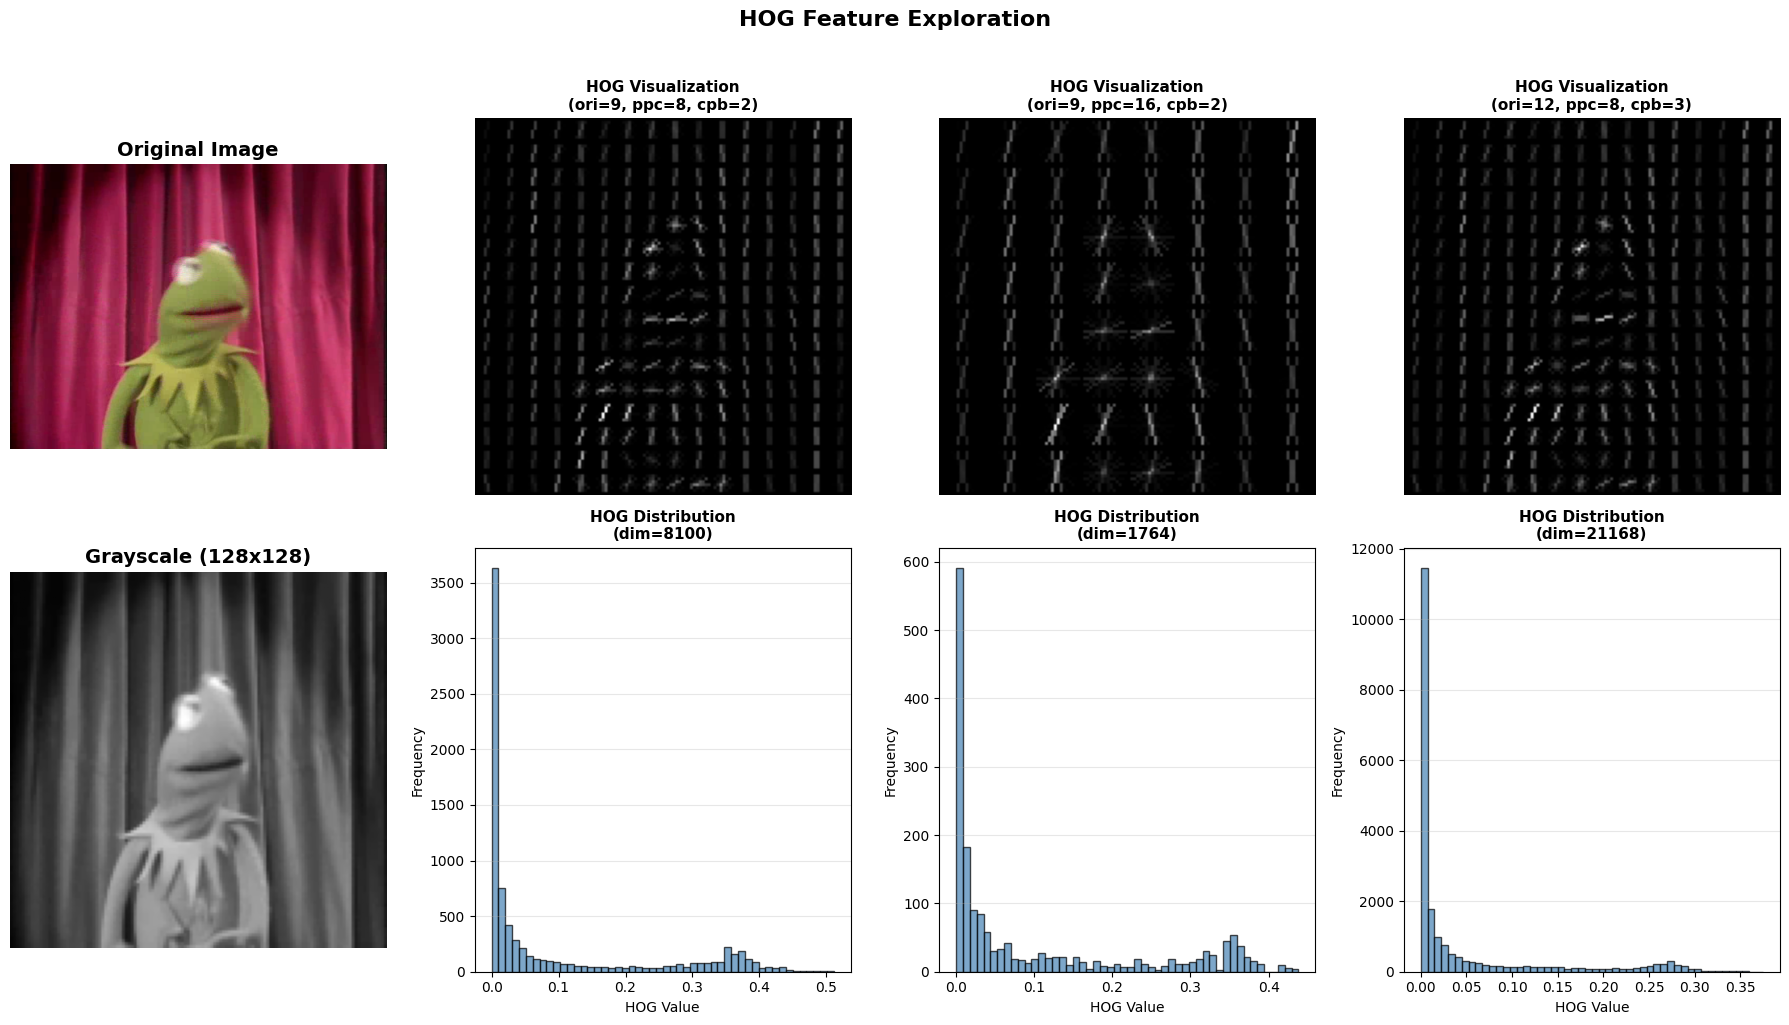


Extracted HOG feature vector (default config):
  Shape: (8100,)
  Min: 0.0000, Max: 0.5111, Mean: 0.0941


In [26]:
ret_frame = load_sample_frame(SAMPLE_VIDEO_FILE, SAMPLE_FRAME_NUMBER)
frame_rgb = cv2.cvtColor(ret_frame, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(ret_frame, cv2.COLOR_BGR2GRAY)
gray_resized = cv2.resize(gray, (128, 128), interpolation=cv2.INTER_AREA)

# Different HOG parameters to explore
hog_configs = [
    {'orientations': 9, 'pixels_per_cell': (8, 8), 'cells_per_block': (2, 2)},
    {'orientations': 9, 'pixels_per_cell': (16, 16), 'cells_per_block': (2, 2)},
    {'orientations': 12, 'pixels_per_cell': (8, 8), 'cells_per_block': (3, 3)},
]

fig, axes = plt.subplots(2, 4, figsize=(18, 10))

# Show original image
axes[0, 0].imshow(frame_rgb)
axes[0, 0].set_title('Original Image', fontsize=14, fontweight='bold')
axes[0, 0].axis('off')

# Show grayscale
axes[1, 0].imshow(gray_resized, cmap='gray')
axes[1, 0].set_title('Grayscale (128x128)', fontsize=14, fontweight='bold')
axes[1, 0].axis('off')

# Compute and display HOG for different parameters
for idx, config in enumerate(hog_configs):
    orientations = config['orientations']
    ppc = config['pixels_per_cell']
    cpb = config['cells_per_block']
    
    # Compute HOG with visualization
    hog_features, hog_image = hog(
        gray_resized,
        orientations=orientations,
        pixels_per_cell=ppc,
        cells_per_block=cpb,
        visualize=True,
        feature_vector=True
    )
    
    # Display HOG visualization
    ax_img = axes[0, idx + 1]
    ax_img.imshow(hog_image, cmap='gray')
    ax_img.set_title(f'HOG Visualization\n(ori={orientations}, ppc={ppc[0]}, cpb={cpb[0]})', 
                     fontsize=11, fontweight='bold')
    ax_img.axis('off')
    
    # Display histogram of HOG features
    ax_hist = axes[1, idx + 1]
    ax_hist.hist(hog_features, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
    ax_hist.set_xlabel('HOG Value', fontsize=10)
    ax_hist.set_ylabel('Frequency', fontsize=10)
    ax_hist.set_title(f'HOG Distribution\n(dim={len(hog_features)})', fontsize=11, fontweight='bold')
    ax_hist.grid(axis='y', alpha=0.3)

plt.suptitle('HOG Feature Exploration', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print feature vector info
print(f"\nExtracted HOG feature vector (default config):")
hog_default = extract_hog_frame(gray_resized)
print(f"  Shape: {hog_default.shape}")
print(f"  Min: {hog_default.min():.4f}, Max: {hog_default.max():.4f}, Mean: {hog_default.mean():.4f}")


### GLCM

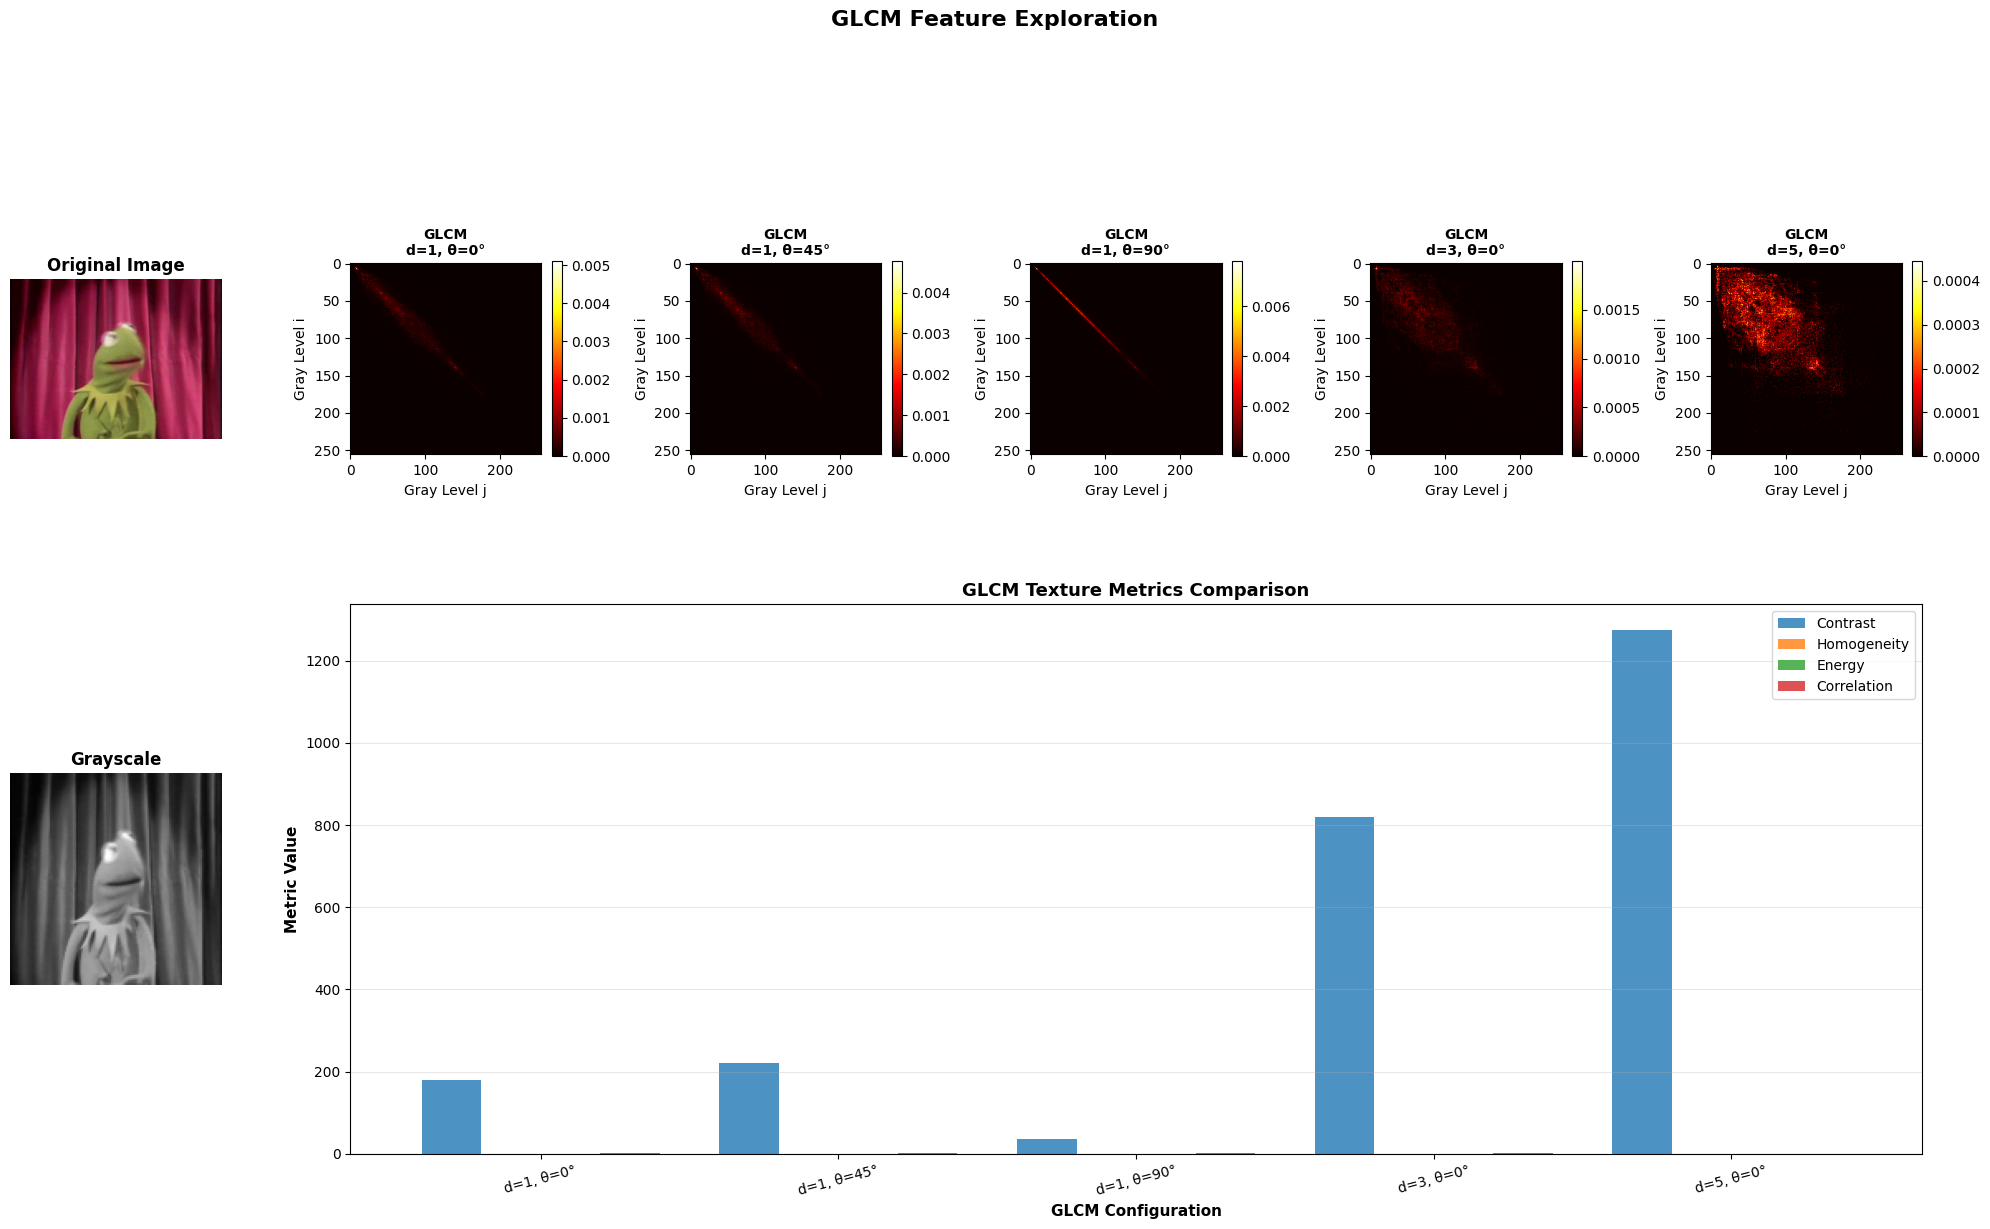


Extracted GLCM feature vector:
  Shape: (2,)
  Contrast: 180.6148, Homogeneity: 0.1487


In [28]:
# Different GLCM parameters to explore
glcm_configs = [
    {'distances': [1], 'angles': [0], 'label': 'd=1, θ=0°'},
    {'distances': [1], 'angles': [np.pi/4], 'label': 'd=1, θ=45°'},
    {'distances': [1], 'angles': [np.pi/2], 'label': 'd=1, θ=90°'},
    {'distances': [3], 'angles': [0], 'label': 'd=3, θ=0°'},
    {'distances': [5], 'angles': [0], 'label': 'd=5, θ=0°'},
]

fig = plt.figure(figsize=(20, 12))

# Top row: Original + GLCM matrices
ax_orig = fig.add_subplot(2, 6, 1)
ax_orig.imshow(frame_rgb)
ax_orig.set_title('Original Image', fontsize=12, fontweight='bold')
ax_orig.axis('off')

ax_gray = fig.add_subplot(2, 6, 7)
ax_gray.imshow(gray_resized, cmap='gray')
ax_gray.set_title('Grayscale', fontsize=12, fontweight='bold')
ax_gray.axis('off')

# Store metrics for comparison chart
metrics_data = {'config': [], 'contrast': [], 'homogeneity': [], 'energy': [], 'correlation': []}

for idx, config in enumerate(glcm_configs):
    # Compute GLCM
    glcm = graycomatrix(gray_resized, distances=config['distances'], 
                        angles=config['angles'], symmetric=True, normed=True)
    
    # Extract properties
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    
    metrics_data['config'].append(config['label'])
    metrics_data['contrast'].append(contrast)
    metrics_data['homogeneity'].append(homogeneity)
    metrics_data['energy'].append(energy)
    metrics_data['correlation'].append(correlation)
    
    # Display GLCM matrix (log scale for visibility)
    ax = fig.add_subplot(2, 6, idx + 2)
    glcm_display = np.log1p(glcm[:, :, 0, 0])  # Log transform for visibility
    im = ax.imshow(glcm_display, cmap='hot')
    ax.set_title(f'GLCM\n{config["label"]}', fontsize=10, fontweight='bold')
    ax.set_xlabel('Gray Level j')
    ax.set_ylabel('Gray Level i')
    plt.colorbar(im, ax=ax, fraction=0.046)

# Bottom row: Metrics comparison bar chart
ax_metrics = fig.add_subplot(2, 6, (8, 12))
x = np.arange(len(glcm_configs))
width = 0.2

bars1 = ax_metrics.bar(x - 1.5*width, metrics_data['contrast'], width, label='Contrast', alpha=0.8)
bars2 = ax_metrics.bar(x - 0.5*width, metrics_data['homogeneity'], width, label='Homogeneity', alpha=0.8)
bars3 = ax_metrics.bar(x + 0.5*width, metrics_data['energy'], width, label='Energy', alpha=0.8)
bars4 = ax_metrics.bar(x + 1.5*width, metrics_data['correlation'], width, label='Correlation', alpha=0.8)

ax_metrics.set_xlabel('GLCM Configuration', fontsize=11, fontweight='bold')
ax_metrics.set_ylabel('Metric Value', fontsize=11, fontweight='bold')
ax_metrics.set_title('GLCM Texture Metrics Comparison', fontsize=13, fontweight='bold')
ax_metrics.set_xticks(x)
ax_metrics.set_xticklabels(metrics_data['config'], rotation=15)
ax_metrics.legend(loc='upper right')
ax_metrics.grid(axis='y', alpha=0.3)

plt.suptitle('GLCM Feature Exploration', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print feature vector info
print(f"\nExtracted GLCM feature vector:")
glcm_default = extract_glcm_frame(gray_resized)
print(f"  Shape: {glcm_default.shape}")
print(f"  Contrast: {glcm_default[0]:.4f}, Homogeneity: {glcm_default[1]:.4f}")

### SIFT

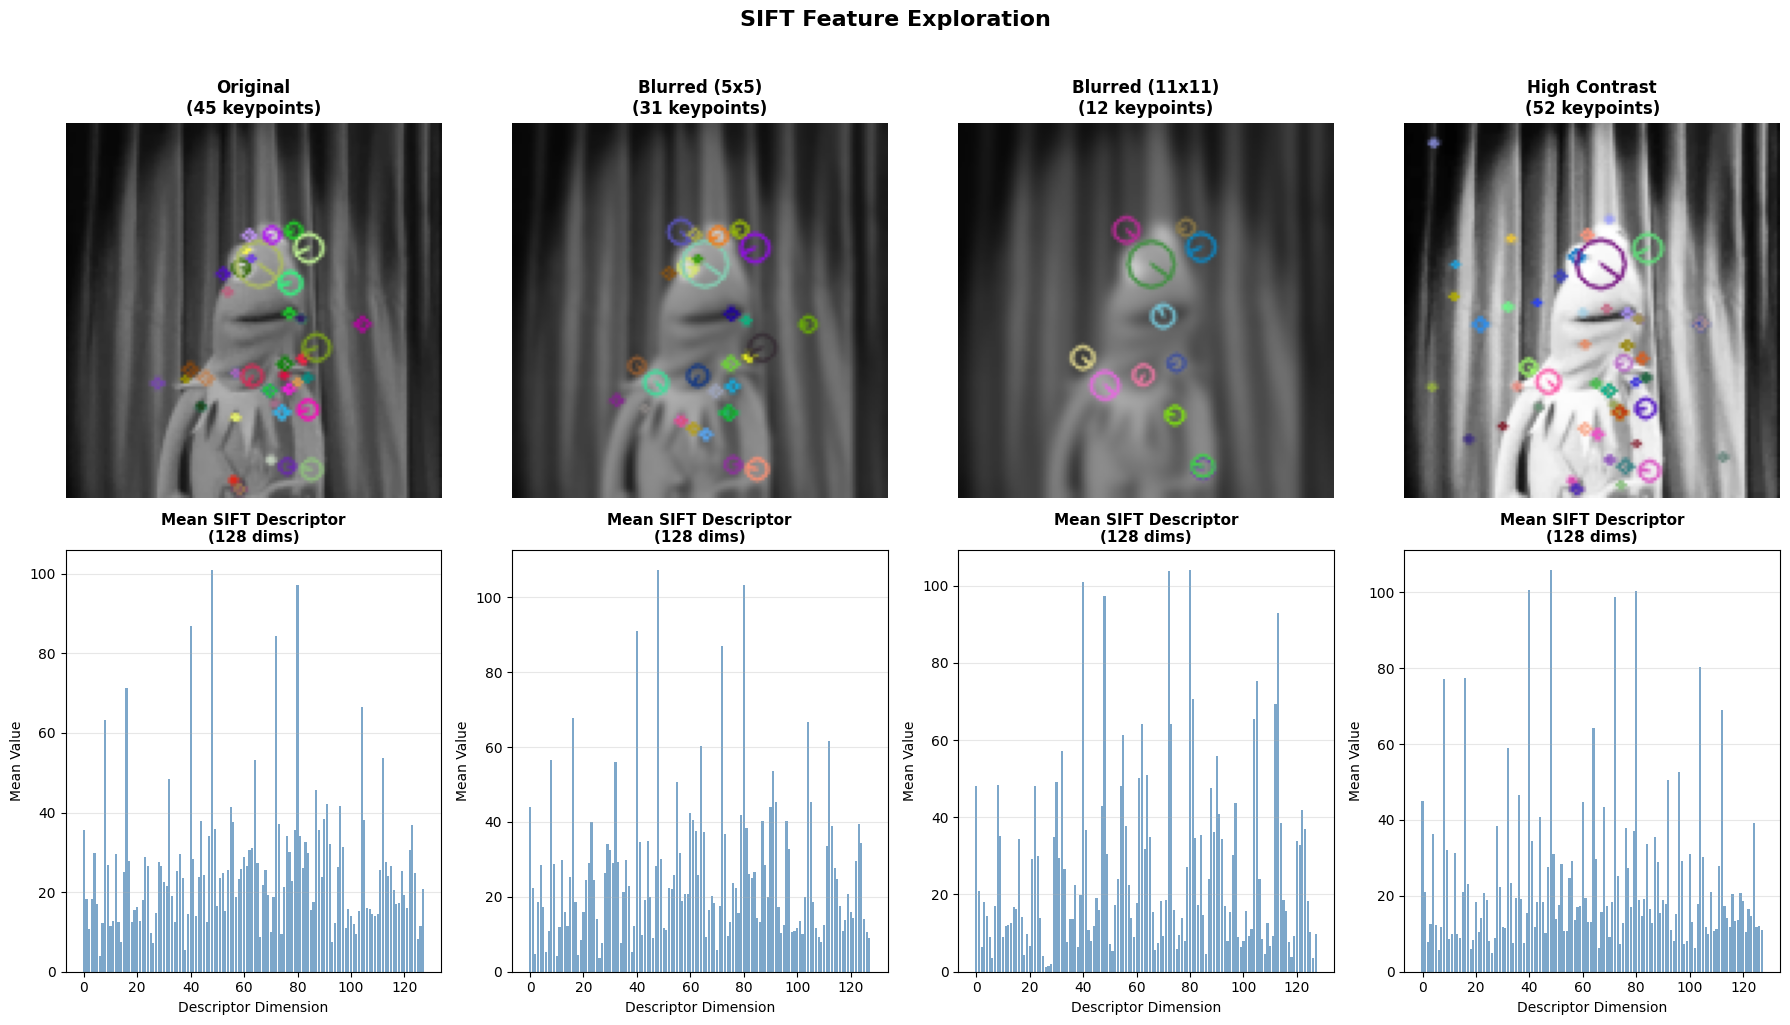


Extracted SIFT feature vector:
  Shape: (128,)
  Min: 4.0667, Max: 100.8222, Mean: 26.1852


In [30]:
sift = cv2.SIFT_create()

# Different images to show SIFT behavior
preprocessing_methods = [
    ('Original', gray_resized),
    ('Blurred (5x5)', cv2.GaussianBlur(gray_resized, (5, 5), 0)),
    ('Blurred (11x11)', cv2.GaussianBlur(gray_resized, (11, 11), 0)),
    ('High Contrast', cv2.equalizeHist(gray_resized)),
]

fig, axes = plt.subplots(2, 4, figsize=(18, 10))

for idx, (name, img) in enumerate(preprocessing_methods):
    # Detect keypoints and compute descriptors
    keypoints, descriptors = sift.detectAndCompute(img, None)
    
    # Draw keypoints on image
    img_with_kp = cv2.drawKeypoints(img, keypoints, None, 
                                     flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    # Top row: Image with keypoints
    axes[0, idx].imshow(img_with_kp)
    axes[0, idx].set_title(f'{name}\n({len(keypoints)} keypoints)', fontsize=12, fontweight='bold')
    axes[0, idx].axis('off')
    
    # Bottom row: Descriptor statistics
    ax_hist = axes[1, idx]
    if descriptors is not None and len(descriptors) > 0:
        # Show distribution of mean descriptor values
        mean_desc = descriptors.mean(axis=0)
        ax_hist.bar(range(len(mean_desc)), mean_desc, color='steelblue', alpha=0.7)
        ax_hist.set_xlabel('Descriptor Dimension', fontsize=10)
        ax_hist.set_ylabel('Mean Value', fontsize=10)
        ax_hist.set_title(f'Mean SIFT Descriptor\n(128 dims)', fontsize=11, fontweight='bold')
        ax_hist.grid(axis='y', alpha=0.3)
    else:
        ax_hist.text(0.5, 0.5, 'No keypoints\ndetected', ha='center', va='center', fontsize=12)
        ax_hist.set_title('No Descriptors', fontsize=11, fontweight='bold')
        ax_hist.axis('off')

plt.suptitle('SIFT Feature Exploration', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print feature vector info
print(f"\nExtracted SIFT feature vector:")
sift_default = extract_sift_frame(gray_resized)
print(f"  Shape: {sift_default.shape}")
print(f"  Min: {sift_default.min():.4f}, Max: {sift_default.max():.4f}, Mean: {sift_default.mean():.4f}")

### LBP

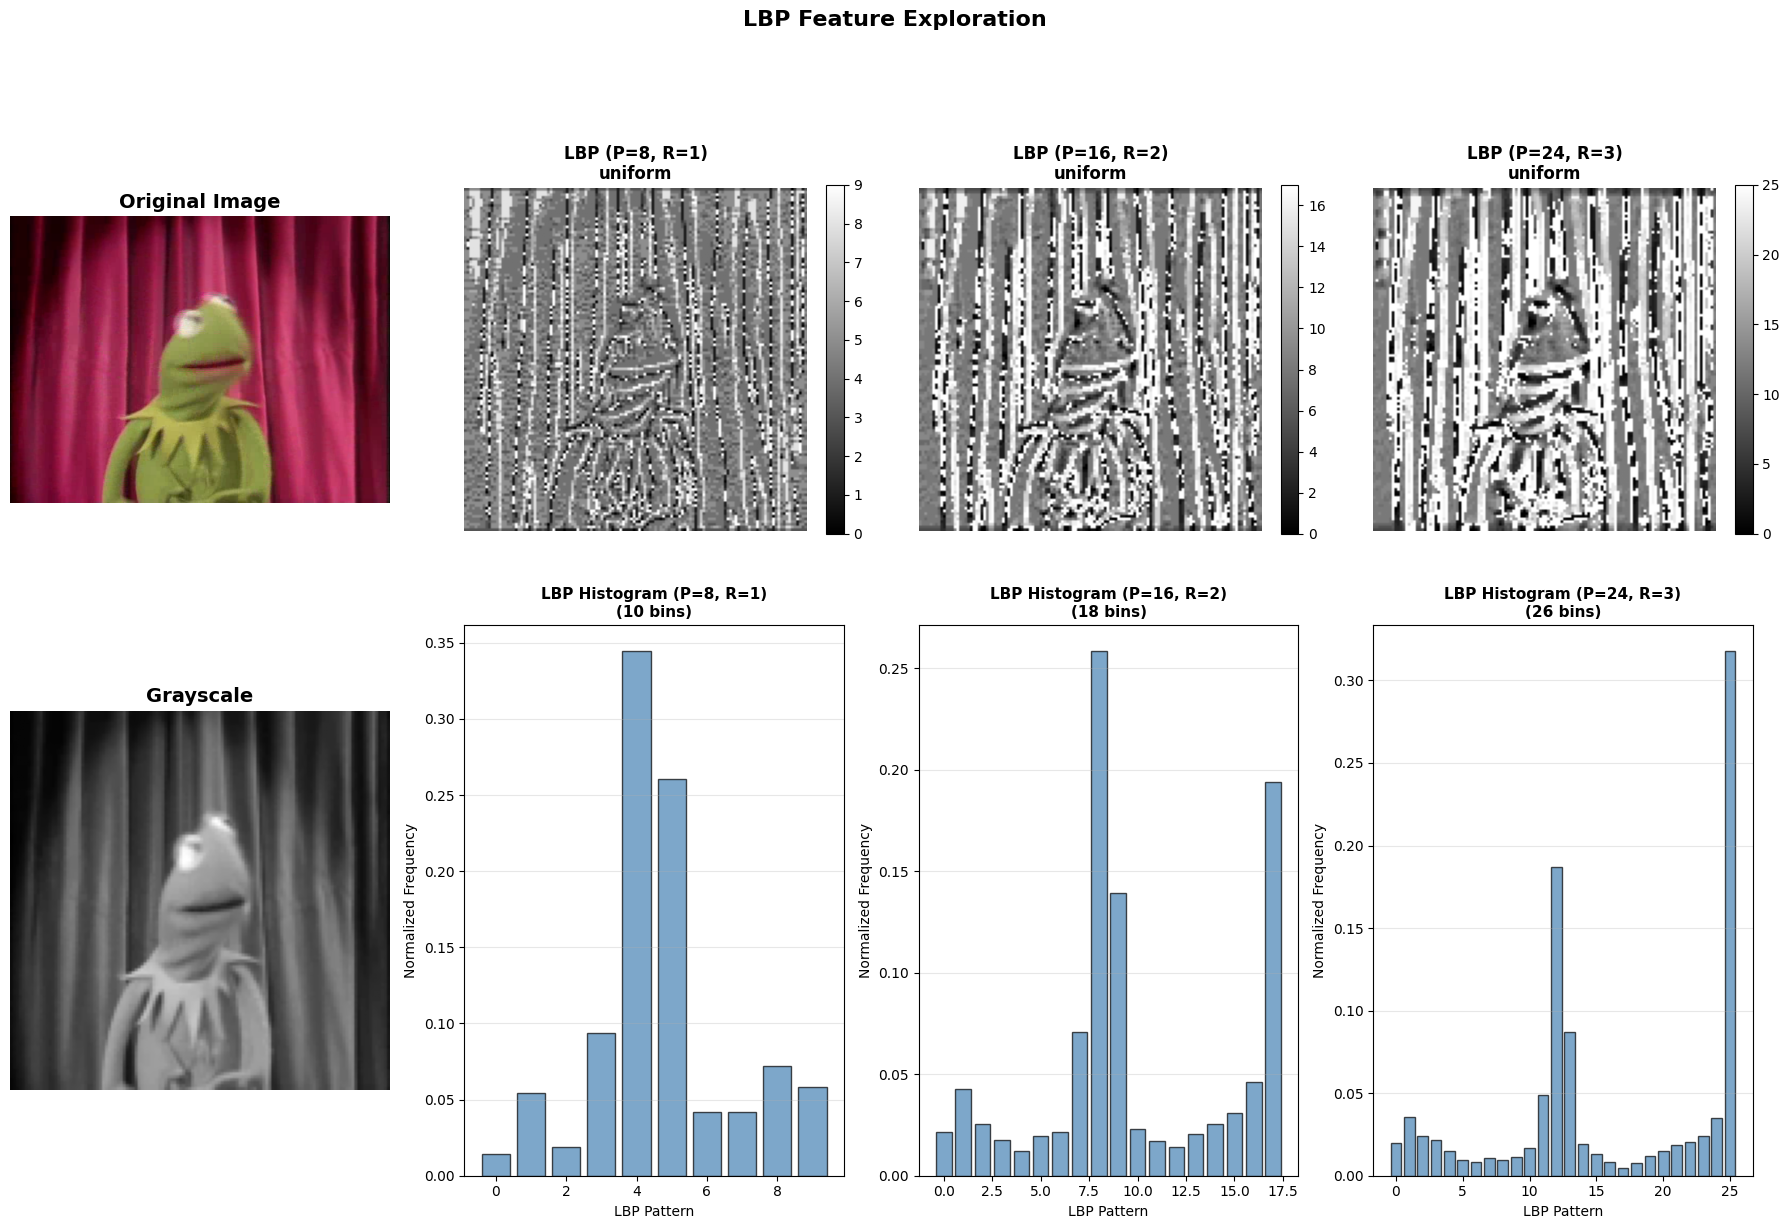


Extracted LBP feature vector:
  Shape: (10,)
  Values: [0.01416016 0.05438232 0.01916504 0.09362793 0.34436035 0.26031494
 0.04156494 0.04156494 0.0723877  0.05847168]


In [31]:
lbp_configs = [
    {'P': 8, 'R': 1},
    {'P': 16, 'R': 2},
    {'P': 24, 'R': 3},
]

fig, axes = plt.subplots(2, 4, figsize=(18, 12))

# Show original image
axes[0, 0].imshow(frame_rgb)
axes[0, 0].set_title('Original Image', fontsize=14, fontweight='bold')
axes[0, 0].axis('off')

# Show grayscale
axes[1, 0].imshow(gray_resized, cmap='gray')
axes[1, 0].set_title('Grayscale', fontsize=14, fontweight='bold')
axes[1, 0].axis('off')

# Compute and display LBP for different parameters
for idx, config in enumerate(lbp_configs):
    P = config['P']
    R = config['R']
    
    # Compute LBP
    lbp = local_binary_pattern(gray_resized, P, R, method='uniform')
    
    # Display LBP image
    ax_img = axes[0, idx + 1]
    im = ax_img.imshow(lbp, cmap='gray')
    ax_img.set_title(f'LBP (P={P}, R={R})\nuniform', fontsize=12, fontweight='bold')
    ax_img.axis('off')
    plt.colorbar(im, ax=ax_img, fraction=0.046)
    
    # Display histogram
    ax_hist = axes[1, idx + 1]
    hist = extract_lbp_frame(gray_resized, P=P, R=R)
    
    ax_hist.bar(range(len(hist)), hist, edgecolor='black', alpha=0.7, color='steelblue')
    ax_hist.set_xlabel('LBP Pattern', fontsize=10)
    ax_hist.set_ylabel('Normalized Frequency', fontsize=10)
    ax_hist.set_title(f'LBP Histogram (P={P}, R={R})\n({len(hist)} bins)', fontsize=11, fontweight='bold')
    ax_hist.grid(axis='y', alpha=0.3)

plt.suptitle('LBP Feature Exploration', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print feature vector info
print(f"\nExtracted LBP feature vector:")
lbp_default = extract_lbp_frame(gray_resized)
print(f"  Shape: {lbp_default.shape}")
print(f"  Values: {lbp_default}")


### All Features

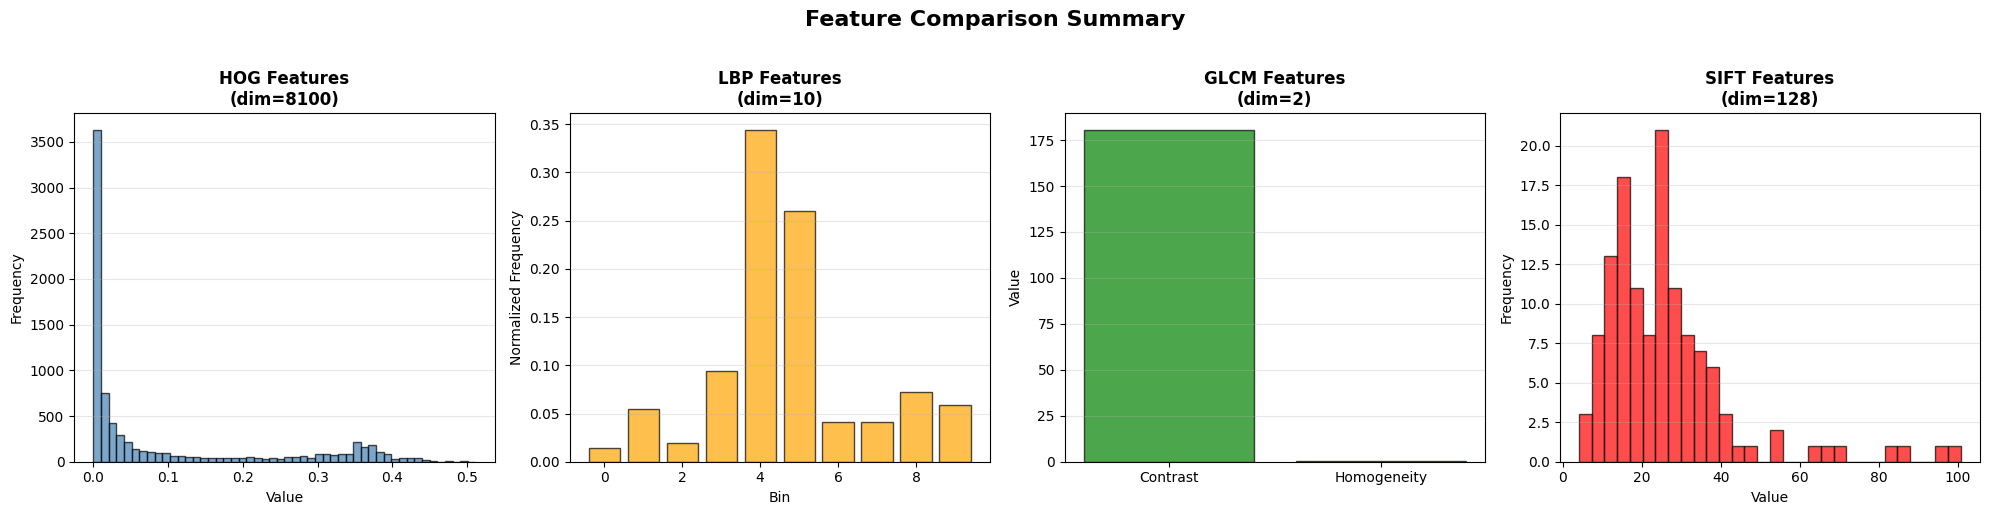


FEATURE DIMENSIONALITY SUMMARY
HOG:    8100 dimensions
LBP:      10 dimensions
GLCM:      2 dimensions
SIFT:    128 dimensions


In [32]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# HOG
axes[0].hist(extract_hog_frame(gray_resized), bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[0].set_title(f'HOG Features\n(dim={len(extract_hog_frame(gray_resized))})', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Frequency')
axes[0].grid(axis='y', alpha=0.3)

# LBP
lbp_feat = extract_lbp_frame(gray_resized)
axes[1].bar(range(len(lbp_feat)), lbp_feat, alpha=0.7, color='orange', edgecolor='black')
axes[1].set_title(f'LBP Features\n(dim={len(lbp_feat)})', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Bin')
axes[1].set_ylabel('Normalized Frequency')
axes[1].grid(axis='y', alpha=0.3)

# GLCM
glcm_feat = extract_glcm_frame(gray_resized)
axes[2].bar(['Contrast', 'Homogeneity'], glcm_feat, alpha=0.7, color='green', edgecolor='black')
axes[2].set_title(f'GLCM Features\n(dim={len(glcm_feat)})', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Value')
axes[2].grid(axis='y', alpha=0.3)

# SIFT
sift_feat = extract_sift_frame(gray_resized)
axes[3].hist(sift_feat, bins=30, alpha=0.7, color='red', edgecolor='black')
axes[3].set_title(f'SIFT Features\n(dim={len(sift_feat)})', fontsize=12, fontweight='bold')
axes[3].set_xlabel('Value')
axes[3].set_ylabel('Frequency')
axes[3].grid(axis='y', alpha=0.3)

plt.suptitle('Feature Comparison Summary', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("FEATURE DIMENSIONALITY SUMMARY")
print("="*60)
print(f"HOG:  {len(extract_hog_frame(gray_resized)):>6} dimensions")
print(f"LBP:  {len(extract_lbp_frame(gray_resized)):>6} dimensions")
print(f"GLCM: {len(extract_glcm_frame(gray_resized)):>6} dimensions")
print(f"SIFT: {len(extract_sift_frame(gray_resized)):>6} dimensions")
print("="*60)

## Building Datasets

In [9]:
def get_label(video_id, frame_idx, gt_df):
    try:
        row = gt_df.loc[(video_id, frame_idx)]
    except KeyError:
        return None

    # 1. Miss Piggy takes the frame.
    # It doesn't matter if 'OtherPigs' is also 1; we define this frame as MissPiggy.
    if row["MissPiggy"] == 1:
        return "MissPiggy"

    # 2. 'OtherPigs' is ONLY valid if Miss Piggy is NOT present.
    # This cleans the data so the model learns "Generic Pig Features" only.
    if row["OtherPigs"] == 1 and row["MissPiggy"] == 0:
        return "OtherPigs"

    # 3. Rest of the classes
    if row["SwedishChef"] == 1:
        return "SwedishChef"
    if row["Rowlf"] == 1:
        return "Rowlf"
        
    return None

def video_iter_frames(path):
    """go through video frame by frame and yield (idx, frame_bgr, fps, nframes)"""
    capture = cv2.VideoCapture(path) # open video
    if not capture.isOpened():
        raise RuntimeError(f"cannot open video: {path}")

    fps = capture.get(cv2.CAP_PROP_FPS) # frames per second
    total_frames = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))

    frame_index = 0
    try:
        while True:
            ok, frame = capture.read() # read next frame
            if not ok:
                break
            yield frame_index, frame, fps, total_frames
            frame_index += 1
    finally:
        capture.release()

In [6]:
if os.path.exists(CACHE_FILE):
    print(f"Cache found at {CACHE_FILE}. Loading finished datasets...")
    with np.load(CACHE_FILE) as data:
        X_hog_frames        = data['X_hog_frames']
        X_lbp_frames        = data['X_lbp_frames']
        X_glcm_frames       = data['X_glcm_frames']
        X_sift_frames       = data['X_sift_frames']
        y_labels            = data['y_labels']
        video_ids_per_frame = data['video_ids_per_frame']
        
    print("Datasets loaded successfully.")

Cache found at ./data/visual_features.npz. Loading finished datasets...
Datasets loaded successfully.


In [11]:
if not os.path.exists(CACHE_FILE):
    # visual features
    hog_features   = []
    lbp_features   = []
    glcm_features  = []
    sift_features  = []

    frame_meta       = []  # list of (video_id, frame_idx)
    labels_per_frame = []

    for video_path in VIDEO_FILES:
        video_id = int(os.path.splitext(os.path.basename(video_path))[0])
        print("processing video:", video_id)

        # get fps and total frames
        cap = cv2.VideoCapture(video_path)
        fps = cap.get(cv2.CAP_PROP_FPS)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.release()

        # loop over frames and grab both visual+audio features
        for frame_idx, frame_bgr, fps, total_frames in video_iter_frames(video_path):
            # get label
            label = get_label(video_id, frame_idx, gt_df)
            if label is None:
                continue

            frame_bgr = cv2.resize(frame_bgr, (128, 128), interpolation=cv2.INTER_LINEAR)
            
            # convert frame to grayscale
            frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
            grayscale = color.rgb2gray(frame_rgb)
            grayscale = (grayscale * 255).astype(np.uint8)

            # meta + label
            frame_meta.append((video_id, frame_idx))
            labels_per_frame.append(label)

            # visual features
            hog_features.append(extract_hog_frame(grayscale))
            lbp_features.append(extract_lbp_frame(grayscale))
            glcm_features.append(extract_glcm_frame(grayscale))
            sift_features.append(extract_sift_frame(grayscale))

    # convert to arrays
    X_hog_frames = np.vstack(hog_features)
    X_lbp_frames = np.vstack(lbp_features)
    X_glcm_frames = np.vstack(glcm_features)
    X_sift_frames = np.vstack(sift_features)
    y_labels = np.array(labels_per_frame)

    meta_array = np.array(frame_meta) 
    video_ids_per_frame = meta_array[:, 0] # frame_meta is a list of (video_id, frame_idx)

processing video: 211
processing video: 343
processing video: 244


In [12]:
if not os.path.exists(CACHE_FILE):
    print("\n================ visual feature matrices ================")
    print("X_hog_frames   :", X_hog_frames.shape)
    print("X_lbp_frames   :", X_lbp_frames.shape)
    print("X_glcm_frames  :", X_glcm_frames.shape)
    print("X_sift_frames  :", X_sift_frames.shape)
    print("\nnumber of labels:", len(y_labels))

    # Save to cache
    print(f"Saving datasets to {CACHE_FILE}...")
    np.savez_compressed(
        CACHE_FILE,
        X_hog_frames=X_hog_frames,
        X_lbp_frames=X_lbp_frames,
        X_glcm_frames=X_glcm_frames,
        X_sift_frames=X_sift_frames,
        y_labels=y_labels,
        video_ids_per_frame=video_ids_per_frame
    )


================ visual feature matrices ================
X_hog_frames   : (29394, 8100)
X_lbp_frames   : (29394, 10)
X_glcm_frames  : (29394, 2)
X_sift_frames  : (29394, 128)

number of labels: 29394
Saving datasets to ./data/visual_features.npz...


### Comparing Features

In [12]:
def evaluate_feature(X, y, name):
    # split once, same split for all features
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=SEED, stratify=y
    )

    # scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test  = scaler.transform(X_test)

    # svm classifier
    clf = SVC(kernel="rbf", C=10, gamma="scale")
    clf.fit(X_train, y_train)

    pred = clf.predict(X_test)
    f1 = f1_score(y_test, pred, average="macro")

    return f1

In [13]:
visual_features = [
    (X_hog_frames, "HOG"),
    (X_lbp_frames, "LBP"),
    (X_glcm_frames, "GLCM"),
    (X_sift_frames, "SIFT"),
]

visual_scores = []
for X, name in visual_features:
    f1 = evaluate_feature(X, y_labels, name)
    visual_scores.append((name, f1))

visual_ranked = sorted(visual_scores, key=lambda x: x[1], reverse=True)

print("\n===== visual ranking =====")
for name, f1 in visual_ranked:
    print(f"{name:12s}  f1 = {f1:.4f}")


===== visual ranking =====
HOG           f1 = 0.9981
SIFT          f1 = 0.9842
LBP           f1 = 0.9570
GLCM          f1 = 0.6765


SIFT and HOG achieve almost perfect visual classification performance with LBP as a close follower and GLCM having a recognizably lower performance. It is therefore not included for subsequent classification tasks.

In [ ]:
def plot_pca_separation(X, y, title="PCA Feature Space"):
    # Reduce to 2 dimensions for plotting
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    # Create a DataFrame for easy plotting with Seaborn
    df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
    df_pca['Label'] = y
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Label', alpha=0.5, palette='tab10')
    plt.title(title)
    plt.show()

In [ ]:
# Use a subset to speed up plotting
subset_idx = np.random.choice(len(y_labels), 2000, replace=False)
plot_pca_separation(X_hog_frames[subset_idx], y_labels[subset_idx], "HOG Feature Separation")

## Classification

In [7]:
def get_train_test_indices(groups, test_size=0.2, random_state=SEED):
    """Splits data so that all frames from one video are EITHER in train OR test."""
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_idx, test_idx = next(gss.split(X=groups, y=groups, groups=groups))
    return train_idx, test_idx

def scale_train_test(X_train, X_test):
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s  = scaler.transform(X_test)
    return X_train_s, X_test_s

In [8]:
# fit once on all labels
label_encoder = LabelEncoder()
y_all_enc = label_encoder.fit_transform(y_labels)

# indices used to split so all models share the same train/test frames
idx_train, idx_test = get_train_test_indices(video_ids_per_frame)

y_train_enc = y_all_enc[idx_train]
y_test_enc = y_all_enc[idx_test]

# split feature sets
ds_visual = np.hstack((X_hog_frames, X_lbp_frames, X_sift_frames))
ds_visual_train = ds_visual[idx_train]
ds_visual_test = ds_visual[idx_test]
ds_visual_train_s, ds_visual_test_s = scale_train_test(ds_visual_train, ds_visual_test)

### MLP

In [9]:
# mlp
cls_mlp = MLPClassifier(
    hidden_layer_sizes=(64,),
    max_iter=200,
    early_stopping=True,
    random_state=SEED
)

# visual
cls_mlp.fit(ds_visual_train_s, y_train_enc)
pred_vis = cls_mlp.predict(ds_visual_test_s)
f1_vis = f1_score(y_test_enc, pred_vis, average="macro")
print(f"[VISUAL] + [MLP] -> F1-Score: {f1_vis:.4f}")

[VISUAL] + [MLP] -> F1-Score: 0.3845


### SVM

In [18]:
cls_svm = SVC(kernel="rbf", C=10.0, gamma="scale", random_state=SEED)
cls_svm.fit(ds_visual_train_s, y_train_enc)
pred_vis_svm = cls_svm.predict(ds_visual_test_s)
print(f"[VISUAL] + [SVM] -> F1-Score: {f1_score(y_test_enc, pred_vis_svm, average='macro'):.4f}")

[VISUAL] + [SVM] -> F1-Score: 0.1499


### Random Forest

In [19]:
cls_rf = RandomForestClassifier(n_estimators=200, random_state=SEED, n_jobs=-1)

# visual
cls_rf.fit(ds_visual_train_s, y_train_enc)
pred_vis_rf = cls_rf.predict(ds_visual_test_s)
print(f"[VISUAL] + [RF] -> F1-Score: {f1_score(y_test_enc, pred_vis_rf, average='macro'):.4f}")

[VISUAL] + [RF] -> F1-Score: 0.1250


### Evaluation

In [20]:
def plot_multiclass_roc(models_dict, X_test, y_test, classes):
    """
    Plot ROC curves for multiple models and multiple classes.
    
    Args:
        models_dict: Dict of {name: fitted_model} (e.g., {'SVM': cls_svm, ...})
        X_test: Scaled test features
        y_test: Integer encoded true labels
        classes: List of class names
    """
    n_classes = len(classes)
    
    # Binarize the labels for One-vs-Rest strategy
    y_test_bin = label_binarize(y_test, classes=range(n_classes))
    
    # Setup plot: One subplot per Class
    fig, axes = plt.subplots(1, n_classes, figsize=(5 * n_classes, 5))
    if n_classes == 1: axes = [axes] # Handle single class edge case
    
    # Define colors for models
    colors = ['blue', 'green', 'red', 'orange', 'purple']
    
    for i, class_name in enumerate(classes):
        ax = axes[i]
        
        # Loop through each model to plot its line on this class's chart
        for model_idx, (model_name, model) in enumerate(models_dict.items()):
            color = colors[model_idx % len(colors)]
            
            # Get probabilities for the specific class (i)
            # shape of probas is (n_samples, n_classes)
            try:
                if hasattr(model, "decision_function"):
                    y_score = model.decision_function(X_test)
                else:
                    y_score = model.predict_proba(X_test)

                if y_score.ndim > 1:
                     y_score_class = y_score[:, i]
                else:
                     # Binary case edge handler
                     y_score_class = y_score
            except AttributeError:
                print(f"Warning: {model_name} failed to produce scores.")
                continue

            # Compute ROC
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score_class)
            roc_auc = auc(fpr, tpr)
            
            ax.plot(fpr, tpr, lw=2, color=color, 
                    label=f'{model_name} (AUC = {roc_auc:.2f})')

        # Formatting the subplot
        ax.plot([0, 1], [0, 1], 'k--', lw=1) # Diagonal random guess
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'ROC: {class_name}')
        ax.legend(loc="lower right")
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

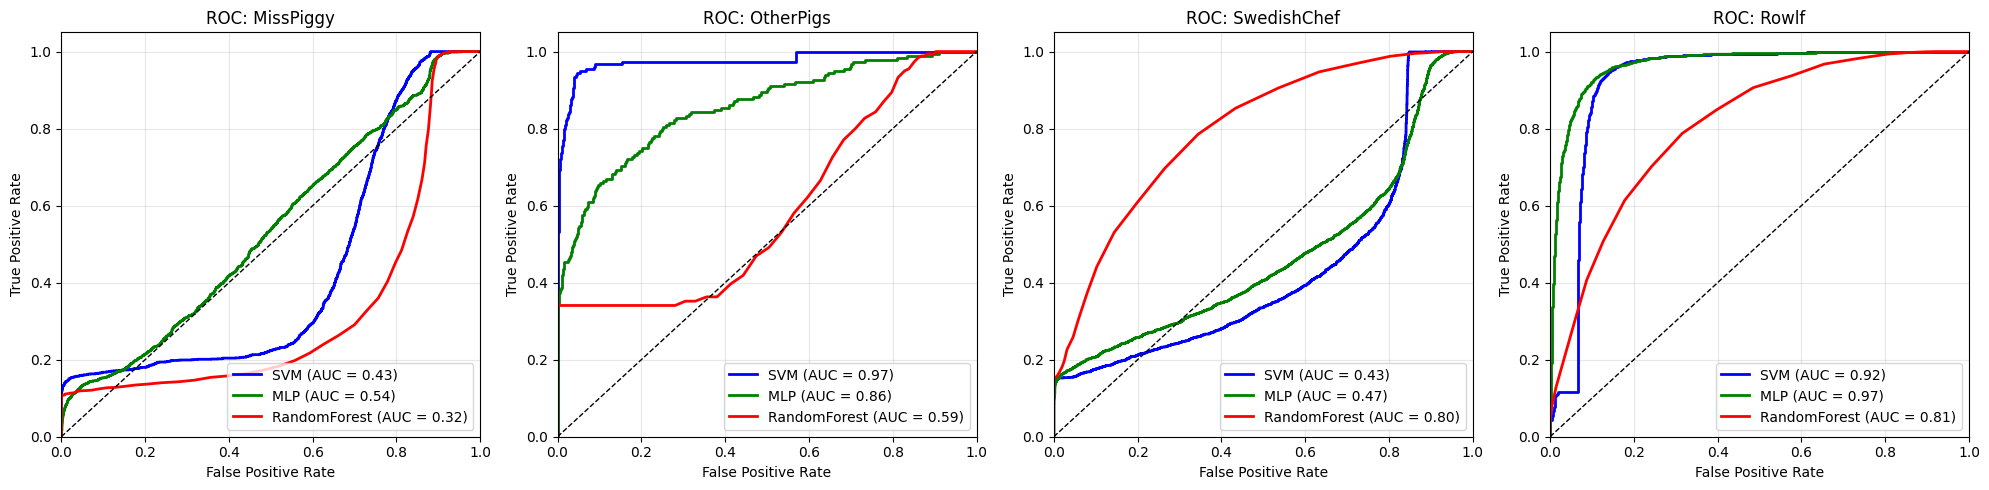

In [21]:
models = { 'SVM': cls_svm,  'MLP': cls_mlp, 'RandomForest': cls_rf }
plot_multiclass_roc(models, ds_visual_test_s, y_test_enc, CLASSES)


--- Detailed Report for MLP ---
              precision    recall  f1-score   support

   MissPiggy       0.26      0.62      0.37      1661
   OtherPigs       0.20      0.55      0.29       179
 SwedishChef       0.53      0.25      0.34      3036
       Rowlf       0.95      0.37      0.54      1730

    accuracy                           0.39      6606
   macro avg       0.48      0.45      0.38      6606
weighted avg       0.56      0.39      0.40      6606



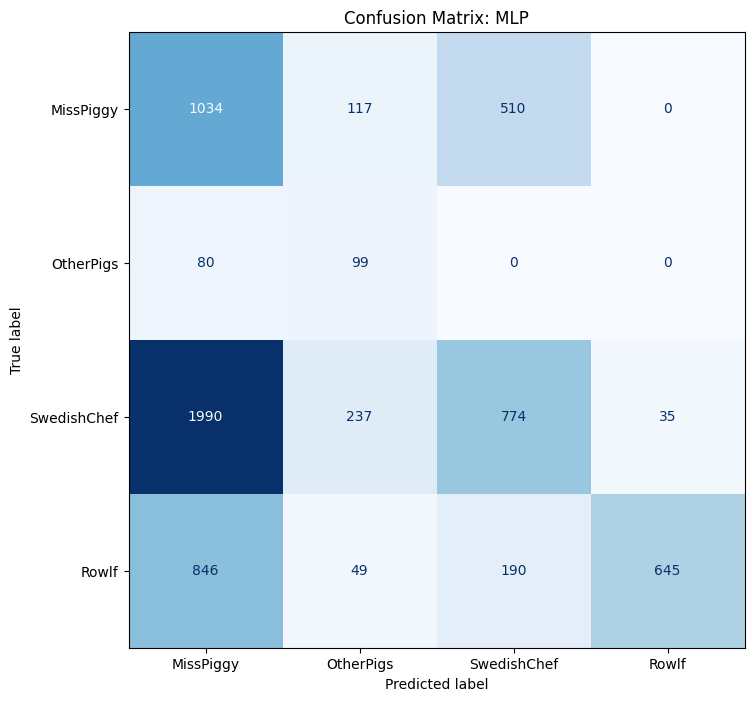

In [10]:
def evaluate_detailed(model, X_test, y_test, class_names, model_name="Model"):
    y_pred = model.predict(X_test)
    
    # 1. Classification Report (Detailed F1/Precision/Recall per class)
    print(f"\n--- Detailed Report for {model_name} ---")
    print(classification_report(y_test, y_pred, target_names=class_names))
    
    # 2. Confusion Matrix Visual
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)
    plt.title(f"Confusion Matrix: {model_name}")
    plt.show()

# Apply to your best model (e.g., SVM) 
# Note: Ensure y_test_enc is inverse transformed to strings if you want string labels, 
# or just pass the encoded integers and the list of CLASSES.
evaluate_detailed(cls_mlp, ds_visual_test_s, y_test_enc, CLASSES, "MLP")

## Discussion

### 5.1 The Issue of Data Leakage and Temporal Correlation

In early iterations of this experiment, we utilized a standard random `train_test_split` across all frames. This yielded near-perfect classification results (ROC AUC $\approx$ 1.0). However, we believe that this performance was due to **data leakage**: Video data is heavily temporally correlated; Frame $t$ is visually almost identical to Frame $t+1$. By splitting randomly, the model was trained on Frame $t$ and tested on Frame $t+1$, essentially allowing it to "memorize" the background and specific scene lighting rather than learning generalizable character features.

To correct this, we implemented `GroupShuffleSplit` based on `video_id`. This ensures that if Episode 1 is in the training set, *no frames* from Episode 1 appear in the test set. The current results (F1 $\approx$ 0.38 for MLP and 0.15 for SVM) are significantly lower than the random split results, but we believe they represent a **more honest generalization capability** of the model to unseen video data.

### 5.2 Best/Worst Feature Performance Analysis
- **HOG:** This was our strongest feature ($F1 \approx 0.99$ in isolation). HOG captures edge directions and shapes, which effectively outlines the distinct silhouettes of the Muppets (e.g., Kermit’s collar, Miss Piggy’s hair) as one can see in the exploration section.
- **GLCM:** This performed poorly ($F1 \approx 0.67$). This was somewhat expected as the Muppets are constructed from similar materials. Therefore texture alone is not a discriminative feature for distinguishing between a pig and a frog made of the same fabric.

### 5.3 Model Behavior
- The MLP classifier outperformed the SVM and Random Forest on the visual data.
- The detailed classification report shows the model struggles most with the "OtherPigs" class. This class lacks a consistent visual definition compared to "Miss Piggy" or "Swedish Chef," causing high false negatives.

### 5.4 Confusion Matrix Analysis (Visual)
The Confusion Matrix for the MLP classifier reveals a specific failure mode:
* **The "Chef-Pig" Confusion:** The model correctly identifies Miss Piggy 1,034 times, but it **misclassifies the Swedish Chef as Miss Piggy 1,990 times**.
* **Hypothesis:** Since our features (HOG, LBP, SIFT) operate on **grayscale** images, the model probably cannot distinguish the pink skin of the pig from the pink skin of the chef. Without color, both characters probably appear as bright, round blobs, distinct from the darker or textured appearance of Rowlf the Dog.
* **Impact:** This suggests that shape and texture alone are insufficient to distinguish these two specific characters. Adding a simple **Color Histogram** feature would likely resolve this confusion immediately.

One has to consider thought that we always use only a single class independent of the amount of figures on screen as the ground truth. Therefore we introduce "artificial" noise in the training data as the model could potentially correctly predict a present figure, but we still label it as wrong.